# Language Models
## Homework 2: Embeddings

**Instructor**: Dr. Pavlos Protopapas<br />
**Maximum Score**: 89


## INSTRUCTIONS

- This homework is a notebook. Download and work on it on your local machine or work on it in Colab.

- This homework should be submitted in a team.

- Ensure you and your partners together have submitted the homework only once. Multiple submissions of the same work will be penalised and will cost you 2 points.

- Please restart the kernel and run the entire notebook again before you submit.

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code works restart the kernel and run the whole notebook again before you submit.

- To submit the homework, either one of you upload the working notebook on edStem and click the submit button on the bottom right corner.

- Submit the homework well before the given deadline. Submissions after the deadline will not be graded.

- We have tried to include all the libraries you may need to do the assignment in the imports statement at the top of this notebook. We strongly suggest that you use those and not others as we may not be familiar with them.

- Comment your code well. This would help the graders in case there is any issue with the notebook while running. It is important to remember that the graders will not troubleshoot your code.

- Please use .head() when viewing data. Do not submit a notebook that is **excessively long**.

- In questions that require code to answer, such as "calculate the $R^2$", do not just output the value from a cell. Write a `print()` function that includes a reference to the calculated value, **not hardcoded**. For example:
```
print(f'The R^2 is {R:.4f}')
```
- Your plots should include clear labels for the $x$ and $y$ axes as well as a descriptive title ("MSE plot" is not a descriptive title; "95 % confidence interval of coefficients of polynomial degree 5" is).

- **Ensure you make appropriate plots for all the questions it is applicable to, regardless of it being explicitly asked for.**

<hr style="height:2pt">

## **Names of the people who worked on this homework**
#### / Wang Hesong/ Chen Taiyi/ Li Yuepeng/ Mao Yuchen/ Yu Lufei/ Zhong Yixiao 

## **Setup Notebook**

**Imports**

In [444]:
import requests
import urllib
import re
import os
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from collections import defaultdict
%matplotlib inline
from IPython.core.display import HTML

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

**Verify Setup**

In [2]:
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.10.0
keras version 2.10.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **PART 1 [25 points]: Word2Vec from scratch**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

Word2Vec architecture allows us to get *contextual* representations of word tokens.     

There are several methods to build a word embedding. We will focus on the SGNS architecture.

![](https://drive.google.com/uc?export=view&id=1eyozbhsrzRaKc86SM7LblgzVMZKAW8Pe)

In this problem, you are asked to build and analyze a Word2Vec architecture trained on Wikipedia articles.

</div>

### **PART 1: Questions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.1 [5 points] Model Processing**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**1.1.1** - Get the data    

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.

- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis
<br />    

**1.1.2** - Build the dataset

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`    
<br />
    
**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    
<br />
    
**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
<br /><br />
    
</details>
    
**1.2 [8 points] Building a Word2Vec model**
<br />
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
<br />

</details>
    
    
**1.3 [7 points] Post-training analysis**

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
This segment involves some simple analysis of your trained embeddings.
<br /><br />
    
    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
        

<br />
    
**1.3.3** - Embedding and Context Matrix
    
    
**1.3.3.1** Investigate the relation between the Embedding & Context matrix. Again use the `cosine_similarity()` function to find the average value across all the words in the embedding and context matrix, i.e:
  - For the word 'dog', find the embedding value, and context value. <br>
  - Calculate the `cosine_similarity()` between the two <br>
  - Repeat the same for every word in the vocabulary and calculate the average value of the `cosine_similarity()`
<br />

**1.3.3.2** Answer the following question and explain:

**Question:** The embedding and context matrices should be identical.
<br /><br />
    
 </details>

**1.4 [5 points] Learning phrases**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>

As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
<br /><br />

    
**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.
<br /><br />
    
**1.4.2** - Retrain word2vec
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000)).
<br /> <br />
</div>

### **PART 1: Solutions**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **1.1 [5 points] Model processing**

**1.1.1** - Get the data  

- Get the data from the `text8.zip` file.
    `text8.zip` is a small, *cleaned* subset of a large corpus of data scraped from Wikipedia pages. More details can be found [here](https://paperswithcode.com/sota/language-modelling-on-text8)
    It is usually used to quickly train, or test language models.
    
- Split the data by whitespace and print the first 10 words to check if has been correctly loaded.

    **NOTE:** For this part of the homework, all words will be in their lowercase for simplicity of analysis   
    </div>

In [39]:
# Helper code to read the data

# Download
urllib.request.urlretrieve("https://github.com/dlops-io/datasets/releases/download/v1.0/text8.zip", "text8.zip")

# Unzip and read data
filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
    vocabulary = tf.compat.as_str(f.read(f.namelist()[0])).split()


In [40]:
print(type(vocabulary))
print(vocabulary[:100])
print(len(vocabulary))

<class 'list'>
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the', 'organization', 'of', 'society', 'it', 'has', 'also', 'been', 'taken', 'up', 'as', 'a', 'positive', 'label', 'by', 'self', 'defined', 'anarchists', 'the', 'word', 'anarchism', 'is', 'derived', 'from', 'the', 'greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy', 'is', 'the', 'belief', 'that', 'rulers', 'are', 'unnecessary', 'and', 'should', 'be', 'abolished', 'although', 'there', 'are', 'differing']
17005207


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.2** - Build the dataset  

- Write a function that takes the `vocabulary_size` and `corpus` as input, and outputs:
    - Tokenized data
    - count of each token
    - A dictionary that maps words to tokens
    - A dictionary that maps tokens to words
    You can use the same function used in **Lab 3**, or else you can use [`tf.keras.Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) to write a similar function.
- Print the first 10 tokens and reverse them to words to confirm a match to the initial print above.
     
  
Eg. `corpus[:10] = ['this','is,'an','example',...]`

`data[:10] = [44,26,24,16,...]`
    
`reversed_data =['this','is,'an','example',...]`

**NOTE**: Choose a sufficiently large vocabulary size. i.e `vocab_size>= 1000`
    
</div>

In [41]:

count_word = {}

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, oov_token='<UNK>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False)
    tokenizer.fit_on_texts(words)
    # Your code here
    # return tokenized data, count_word, count_id, word_to_id, id_to_word:
    return tokenizer.texts_to_sequences(words), tokenizer.word_counts, {tokenizer.word_index[key] : val for key, val in tokenizer.word_counts.items()}, tokenizer.word_index, tokenizer.index_word

In [42]:
vocab_size = 3000
data, count_word, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                                vocab_size)
del vocabulary  # Hint to reduce memory.

In [43]:
print("data[:10] = ",data[:10])
reversed_sample10 = [reverse_dictionary[i[0]] for i in data[:10]]
print("reversed_data[:10] = ", reversed_sample10)

data[:10] =  [[1], [1], [13], [7], [196], [3], [1], [47], [60], [157]]
reversed_data[:10] =  ['<UNK>', '<UNK>', 'as', 'a', 'term', 'of', '<UNK>', 'first', 'used', 'against']


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.3** - Build skipgrams with negative samples
- Use the `tf.keras.preprocessing.sequence.skipgrams` function to build positive and negative samples \
    for word2vec training. Follow the documentation on how to make the pairs
- You are free to choose your own `window_size`, but we recommend a value of 3.
- Print 10 pairs of *center* and *context* words with their associated labels.    
    
Skip-gram Sampling table
A large dataset means a larger vocabulary with a higher number of more frequent words such as stopwords. Training examples obtained from sampling commonly occurring words (such as the, is, on) don't add much useful information for the model to learn from. [Mikolov et al.](https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf) suggest subsampling of frequent words as a helpful practice to improve embedding quality.

The `tf.keras.preprocessing.sequence.skipgrams` function accepts a sampling table argument to encode probabilities of sampling any token. You can use the `tf.keras.preprocessing.sequence.make_sampling_table` to generate a word-frequency rank-based probabilistic sampling table and pass it to skipgrams function.    

</div>

In [44]:
# use tf.keras.preprocessing.sequence.skipgrams to build positive and negative samples for word2vec training
# window_size = 3
# Your code here:
sample_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
couples, labels = tf.keras.preprocessing.sequence.skipgrams(data, vocab_size, window_size=3, sampling_table=sample_table)

In [45]:
# print 10 pairs of center and context words with labels:
for i in range(10):
    print(f'word pairs: {couples[i]}, label: {labels[i]}')

word pairs: [[2807], 721], label: 0
word pairs: [[437], [2]], label: 1
word pairs: [[2141], [1]], label: 1
word pairs: [[2174], 1289], label: 0
word pairs: [[315], 1584], label: 0
word pairs: [[1169], 2572], label: 0
word pairs: [[1666], [4]], label: 1
word pairs: [[15], 2494], label: 0
word pairs: [[1797], 2294], label: 0
word pairs: [[400], [1]], label: 1


In [46]:
print(len(couples))
print(couples[5])
print(type(couples[5][1]))
print(type(couples[5][0]))

17886888
[[1169], 2572]
<class 'int'>
<class 'list'>


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.1.4** - What is the difference between using a sampling table and not using a sampling table while building the dataset for skipgrams?
    
</div>

The difference is, without using a sampling table, the dataset for training will consist of a large proportion of frequently occurred words like "the", "and", etc, which will make the word embedding focus too much on those frequently used but less informative words, thus causing the word embeddings to be of low qualities. By using a sample table, when we use skipgrams to build dataset, it will subsample words with high frequency, thus allowing more informative word pairs to be included in dataset, which will achieve a better representation embedding.

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.2 [8 points]** **Building a word2vec model**

Build a word2vec model architecture based on the schematic below.


![](https://drive.google.com/uc?export=view&id=1fBTpoBoG5RZIPTtdogZt37Bw3oUb7tuT)
  
    
- To do so, you will need:
    - `tf.keras.layers.Embedding` layer
    - `tf.keras.layers.Dot()`
    - `tf.keras.Model()` which is the functional API
- You can choose an appropriate embedding dimension
- Compile the model using `binary_crossentropy()` function and an appropriate optimizer.
- Sufficiently train the model.    
- Save model weights using the `model.save_weights()` for analysis of **2.3**. More information on saving your weights [here](https://www.tensorflow.org/tutorials/keras/save_and_load)    
    
</div>

In [47]:
# Your code here
def build_model_w2v():
    embedding_dim = 64
    input_center = tf.keras.layers.Input(shape=(1,))
    input_context = tf.keras.layers.Input(shape=(1,))
    # shape of input_center: (None, 1)
    embedding_center = tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=1, name='embedding_center')(input_center)
    embedding_context = tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=1, name='embedding_context')(input_context)
    # shape of embedding_center: (None, 1, 64)
    # reshape to (None, 64):
    embedding_center = tf.keras.layers.Reshape((embedding_dim,))(embedding_center)
    embedding_context = tf.keras.layers.Reshape((embedding_dim,))(embedding_context)
    # shape of embedding_center: (None, 64)
    # Dot product of two tensors:
    dot_product = tf.keras.layers.Dot(axes=1, normalize=False)([embedding_center, embedding_context])
    # shape of dot_product: (None, 1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dot_product)
    model = tf.keras.Model(inputs=[input_center, input_context], outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [48]:
for i in range(len(couples)):
    # if the element is a list return list[0] else return the element:
    if type(couples[i][0]) == list:
        couples[i][0] = couples[i][0][0]
    if type(couples[i][1]) == list:
        couples[i][1] = couples[i][1][0]

In [49]:
for i in range(10):
    print(f"word pairs : {couples[i]}, labels : {labels[i]}")

word pairs : [2807, 721], labels : 0
word pairs : [437, 2], labels : 1
word pairs : [2141, 1], labels : 1
word pairs : [2174, 1289], labels : 0
word pairs : [315, 1584], labels : 0
word pairs : [1169, 2572], labels : 0
word pairs : [1666, 4], labels : 1
word pairs : [15, 2494], labels : 0
word pairs : [1797, 2294], labels : 0
word pairs : [400, 1], labels : 1


In [60]:
# split the couples into X_center and X_context:
couples = np.array(couples, dtype = np.int32)
X_center = couples[:,0]
X_context = couples[:,1]
y_labels = np.array(labels, dtype = np.int32)
X_center = X_center.reshape(-1,1)
X_context = X_context.reshape(-1,1)
y_labels = y_labels.reshape(-1,1)

In [61]:
for i in range(10):
    print(f"X_center: {X_center[i]}")
    print(f"labels: {labels[i]}")

X_center: [2807]
labels: 0
X_center: [437]
labels: 1
X_center: [2141]
labels: 1
X_center: [2174]
labels: 0
X_center: [315]
labels: 0
X_center: [1169]
labels: 0
X_center: [1666]
labels: 1
X_center: [15]
labels: 0
X_center: [1797]
labels: 0
X_center: [400]
labels: 1


In [62]:
print(len(dictionary))
print(len(count))
print(X_center.shape)
print(type(labels))
print(type(labels[0]))

253855
253854
(17886888, 1)
<class 'list'>
<class 'int'>


In [64]:
# train the model:
model_w2v = build_model_w2v()
history_w2v = model_w2v.fit([X_center, X_context], y_labels, epochs=10, batch_size=128, shuffle=True)
# save the weights of the model:
model_w2v.save_weights('model_w2v.h5')

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_center (Embedding)   (None, 1, 64)        192064      ['input_15[0][0]']               
                                                                                                  
 embedding_context (Embedding)  (None, 1, 64)        192064      ['input_16[0][0]']               
                                                                                            

Epoch 1/10
139742/139742 [==============================] - 303s 2ms/step - loss: 0.3501 - accuracy: 0.8480
Epoch 2/10
139742/139742 [==============================] - 399s 3ms/step - loss: 0.3306 - accuracy: 0.8572
Epoch 3/10
139742/139742 [==============================] - 296s 2ms/step - loss: 0.3255 - accuracy: 0.8597
Epoch 4/10
139742/139742 [==============================] - 305s 2ms/step - loss: 0.3228 - accuracy: 0.8610
Epoch 5/10
139742/139742 [==============================] - 383s 3ms/step - loss: 0.3212 - accuracy: 0.8619
Epoch 6/10
139742/139742 [==============================] - 331s 2ms/step - loss: 0.3202 - accuracy: 0.8623
Epoch 7/10
139742/139742 [==============================] - 307s 2ms/step - loss: 0.3196 - accuracy: 0.8626
Epoch 8/10
139742/139742 [==============================] - 282s 2ms/step - loss: 0.3192 - accuracy: 0.8629
Epoch 9/10
139742/139742 [==============================] - 285s 2ms/step - loss: 0.3191 - accuracy: 0.8629
Epoch 10/10
139742/139742 [=

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.3 [7 points] Post-training analysis**
    
This segment involves some simple analysis of your trained embeddings.

    
**1.3.1** - Vector Algebra on Embeddings

Assuming you have chosen a sufficiently large `vocab_size`, find the embeddings for:
    
1. King
2. Male
3. Female
4. Queen
    
Find the vector `v = King - Male + Female` and find its `cosine_similarity()` with the embedding for 'Queen'.
You can use the `cosine_similarity()` function defined in the session 3 exercise.

**NOTE**:The `cosine_similarity()` value, must be greater than `0.9`; If it is not, this implies that your word2vec embeddings are not well-trained.

Write a function `most_similar()`, which finds the top-n words most similar to the given word. Use this function to find the words most similar to `king`.
    <br />
    <br />
    
**Conceptual Question** Why can't we use `cosine_similarity()` as a `loss_function`?
    
<br />
    
</div>

In [65]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [66]:
# Find embeddings for King, Male, Female, Queen:
test_words = ['king', 'male', 'female', 'queen']
# Your code here:
# Step 1: load the embedding_center embedding matrix from model_w2v:
embedding_center_layer = model_w2v.get_layer('embedding_center')
# Step 2: get the weights of the embedding layer:
center_weights = embedding_center_layer.get_weights()[0]
# Step 3: find the int token of each word in test_words:
test_words_int = [dictionary[word] for word in test_words]
# Step 4: find the embedding of each word in test_words:
test_words_embedding = center_weights[test_words_int]

# Find v = King - Male + Female:
v = test_words_embedding[0] - test_words_embedding[1] + test_words_embedding[2]
# Fine cosine_similarity between v and Queen:
cosine_similarity_vq = cosine_similarity(v, test_words_embedding[3])

print('cosine_similarity of v and queen =', cosine_similarity_vq)

cosine_similarity of v and queen = 0.7687743


In [211]:
def most_similar(word_embedding, embedding_matrix, k=5):
    """Returns the k most similar words to a given word."""
    # YOUR CODE HERE
    top_k = []
    row_matrix = embedding_matrix.shape[0]
    for i in range(row_matrix):
        ith_word_embedding = embedding_matrix[i]
        cosine_similarity_iw = cosine_similarity(embedding_matrix[i], word_embedding)
        # if ith cosine similarity is greater than the last element of top_k, insert it in top_k and sort top_k then remove the last element:
        if len(top_k) < k:
            top_k.append((cosine_similarity_iw, i + 1))
            top_k.sort(key=lambda tup: tup[0], reverse=True)
        elif cosine_similarity_iw > top_k[-1][0]:
            top_k.append((cosine_similarity_iw, i + 1))
            top_k.sort(key=lambda tup: tup[0], reverse=True)
            top_k.pop()
    return top_k

In [213]:
# find the top10 words that most similar to king:
king_top10 = most_similar(test_words_embedding[0], center_weights, 10)
for i in range(10):
    print(f"the {i+1}-th most similar word of king is : ", reverse_dictionary[king_top10[i][1]])

the 1-th most similar word of king is :  law
the 2-th most similar word of king is :  elected
the 3-th most similar word of king is :  occur
the 4-th most similar word of king is :  ex
the 5-th most similar word of king is :  claims
the 6-th most similar word of king is :  express
the 7-th most similar word of king is :  placed
the 8-th most similar word of king is :  allowing
the 9-th most similar word of king is :  contract
the 10-th most similar word of king is :  trying


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

    
**1.3.2** - Visualizing Embeddings

Find the embeddings for the words:
1. 'January'
2. 'February'
3. 'March'
4. 'April'
    
Find the `cosine_similarity()` of 'january' with each of 'february`, 'march', 'april' (which should be high values).
    
Save your trained weights. Recreate the network you have created above and initialize it with random weights. Compute the `cosine_similarity()` values. The values should be small (because the embeddings are random).
    
Use a demonstrative plot to show the `before & after` of the 4 embeddings. Here are some suggestions:
    1. PCA/TSNE for dimensionality reduction
    2. Radar plot to show all embedding dimensions
    
Bonus points for using creative means to demonstrate how the embeddings change after training.

Here is a [video](https://youtu.be/VDl_iA8m8u0) of a sample demonstration. We used a custom callback to get embeddings during training.  
            
</div>

In [70]:
# Your code here
test_words_132 = ['january', 'february', 'march', 'april']
# the embedding matrix is stored in center_weights;
# find the int token for each word in test_words_132:
test_words_132_ints = [dictionary[word] for word in test_words_132]
# get the embedding vectors for each word:
test_words_132_embeddings = center_weights[test_words_132_ints]
# compute cosine similarity of 'january' with each of the other words:
january_cos_sims = []
for i in range(len(test_words_132)):
    if i != 0:
        january_cos_sims.append(cosine_similarity(test_words_132_embeddings[0], test_words_132_embeddings[i]))
# print the results:
for i in range(len(test_words_132)):
    if i != 0:
        print('cosine similarity of january -', test_words_132[i], ':', january_cos_sims[i-1])

cosine similarity of january - february : 0.9371794
cosine similarity of january - march : 0.9383798
cosine similarity of january - april : 0.93542707


## Bonus Part

In [71]:
# recreate the network with initialized random weights:
model_random_w2v = build_model_w2v()
# get the weights of embedding_center layer:
weights_random_w2v = model_random_w2v.get_layer('embedding_center').get_weights()[0]

# compute the cosine similarity of 'january' with each of the other words in test_words_132:
january_cos_sims_random = []
for i in range(len(test_words_132)):
    if i != 0:
        january_cos_sims_random.append(cosine_similarity(weights_random_w2v[0], weights_random_w2v[i]))
# print the results:
for i in range(len(test_words_132)):
    if i != 0:
        print('Random Cosine similarity between january and', test_words_132[i], 'is:', january_cos_sims_random[i-1])
        

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_center (Embedding)   (None, 1, 64)        192064      ['input_17[0][0]']               
                                                                                                  
 embedding_context (Embedding)  (None, 1, 64)        192064      ['input_18[0][0]']               
                                                                                            

In [200]:
# get the initialized random embeddings for words in test_words_132:
initial_embeddings_random_w2v = []
for word in test_words_132:
    initial_embeddings_random_w2v.append(weights_random_w2v[dictionary[word]])

In [76]:
# define a callback class to record the weights during epochs:
class EmbeddingWeightsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EmbeddingWeightsCallback, self).__init__()
        self.word_list = ["january", "february", "march", "april"]
        self.weights_history = []

    def on_epoch_end(self, epoch, logs=None):
        embedding_layer = self.model.get_layer("embedding_center")
        embedding_weights = embedding_layer.get_weights()[0]
        # record the embedding weights for each word in word_list:
        word_embeddings = []
        for word in self.word_list:
            word_index = dictionary[word]
            word_embeddings.append(embedding_weights[word_index])
        # shape of word_embeddings: (4, embedding_dim)
        self.weights_history.append(word_embeddings)
        # shape of weights_history: (num_epochs, 4, embedding_dim)

In [79]:
# train the model_random_w2v:
embedding_callback = EmbeddingWeightsCallback()
history_random_w2v = model_random_w2v.fit([X_center, X_context], y_labels, epochs=10, batch_size=128, shuffle=True, callbacks=[embedding_callback])

Epoch 1/10
139742/139742 [==============================] - 287s 2ms/step - loss: 0.3294 - accuracy: 0.8578
Epoch 2/10
139742/139742 [==============================] - 288s 2ms/step - loss: 0.3250 - accuracy: 0.8600
Epoch 3/10
139742/139742 [==============================] - 288s 2ms/step - loss: 0.3226 - accuracy: 0.8611
Epoch 4/10
139742/139742 [==============================] - 295s 2ms/step - loss: 0.3211 - accuracy: 0.8618
Epoch 5/10
139742/139742 [==============================] - 294s 2ms/step - loss: 0.3201 - accuracy: 0.8623
Epoch 6/10
139742/139742 [==============================] - 297s 2ms/step - loss: 0.3196 - accuracy: 0.8626
Epoch 7/10
139742/139742 [==============================] - 294s 2ms/step - loss: 0.3192 - accuracy: 0.8628
Epoch 8/10
139742/139742 [==============================] - 293s 2ms/step - loss: 0.3192 - accuracy: 0.8629
Epoch 9/10
139742/139742 [==============================] - 294s 2ms/step - loss: 0.3191 - accuracy: 0.8629
Epoch 10/10
139742/139742 [=

In [94]:
import sklearn
from sklearn.decomposition import PCA

In [201]:
# get embedding_weights_list from embedding_callback
epochs_weights_list = embedding_callback.weights_history
#insert initial_embeddings_random_w2v to the beginning of the list:
epochs_weights_list.insert(0, initial_embeddings_random_w2v)

# shape of weights_list: (epochs, 4, embedding_dim)
num_epochs_random_w2v = len(epochs_weights_list)
num_words_random_w2v = len(epochs_weights_list[0])
embedding_dim_random_w2v = len(epochs_weights_list[0][0])
word_embeddings_2d_random_w2v = np.zeros((num_epochs_random_w2v, num_words_random_w2v, 2))
colors_w2v = ['r', 'g', 'b', 'm']
# get 2d embeddings for each epoch:
pca = sklearn.decomposition.PCA(n_components=2)
word_embeddings_2d_random_w2v[0] = pca.fit_transform(epochs_weights_list[0])
for epoch in range(num_epochs_random_w2v - 1):
    word_embeddings_2d_random_w2v[epoch + 1] = pca.transform(epochs_weights_list[epoch + 1])


C:\Users\19595\AppData\Local\Temp\ipykernel_11616\3164102955.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(1, 2, 2, projection='polar')


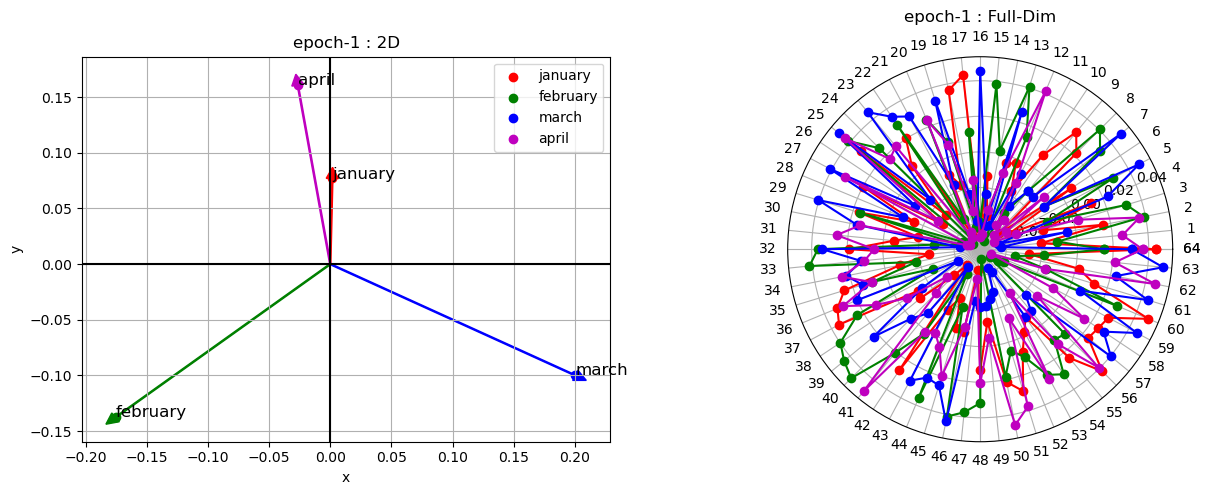

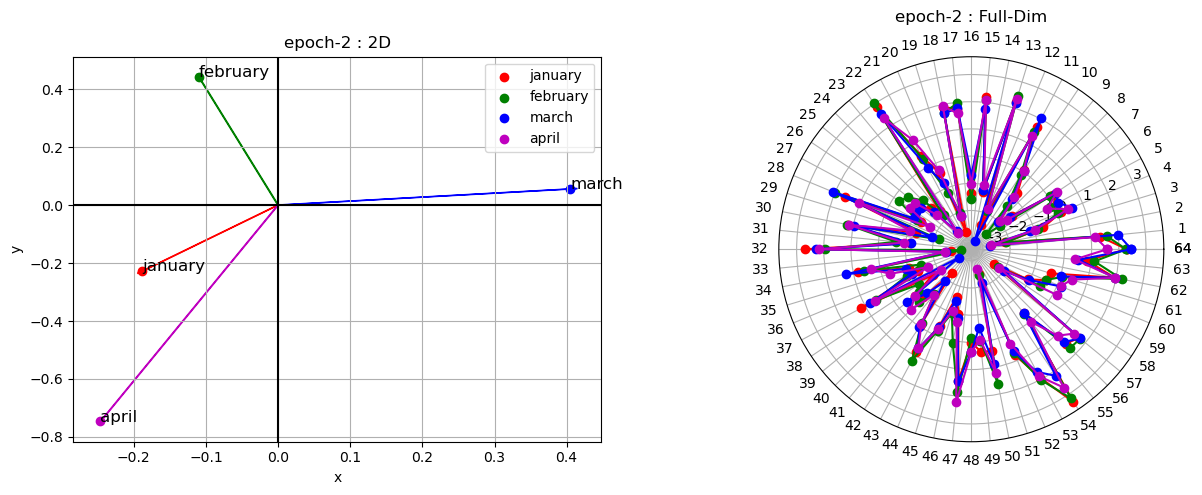

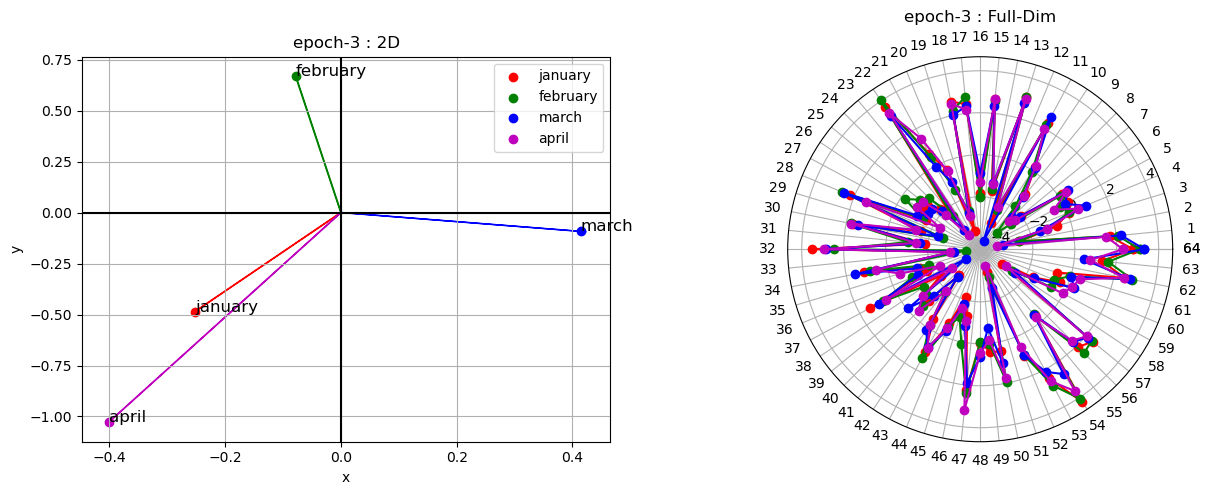

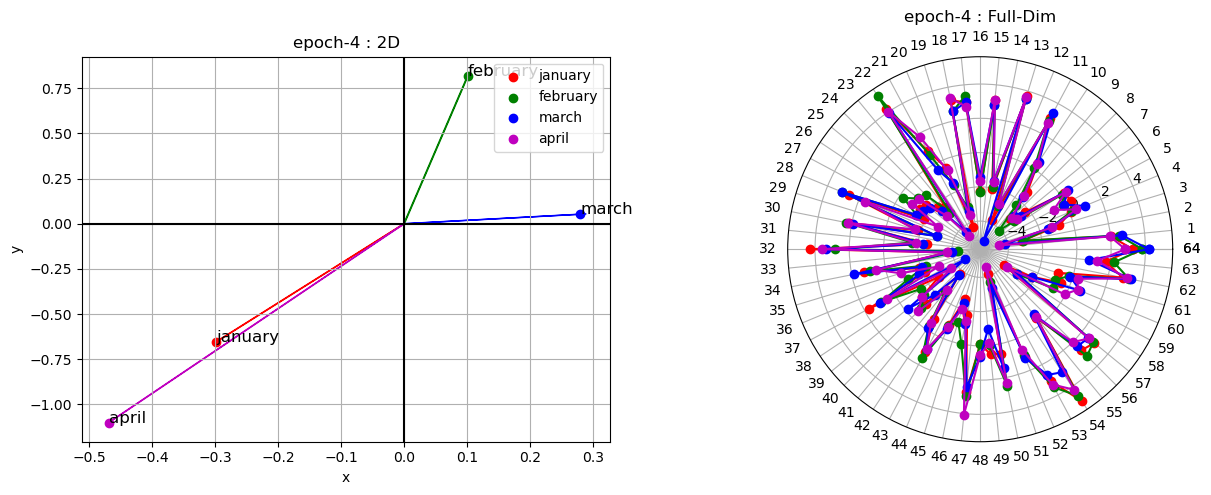

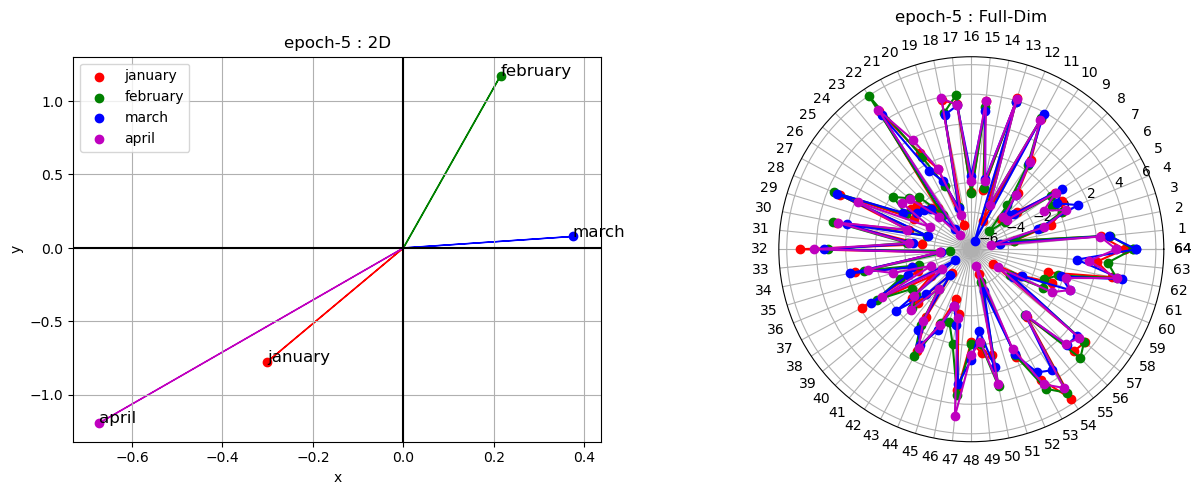

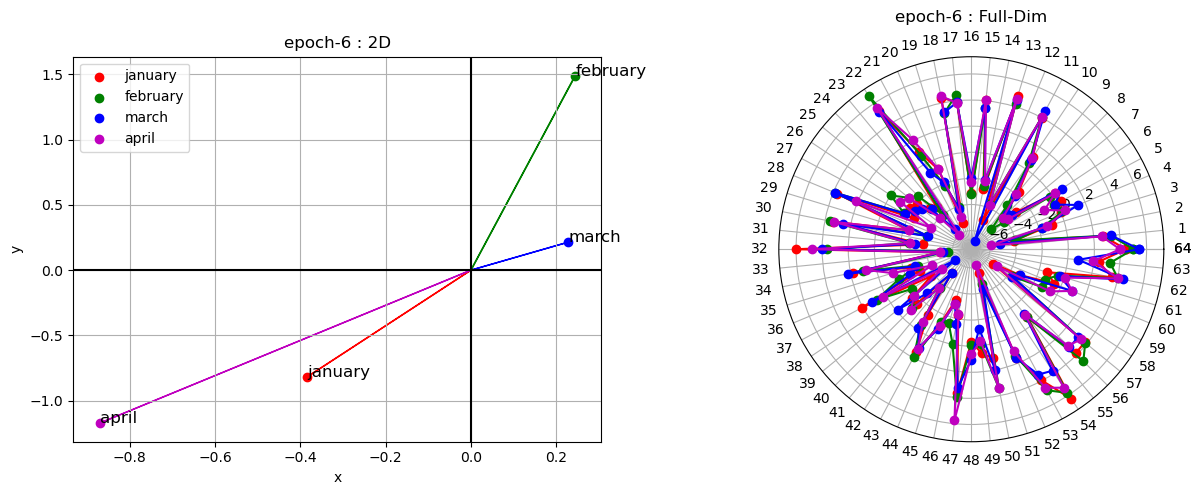

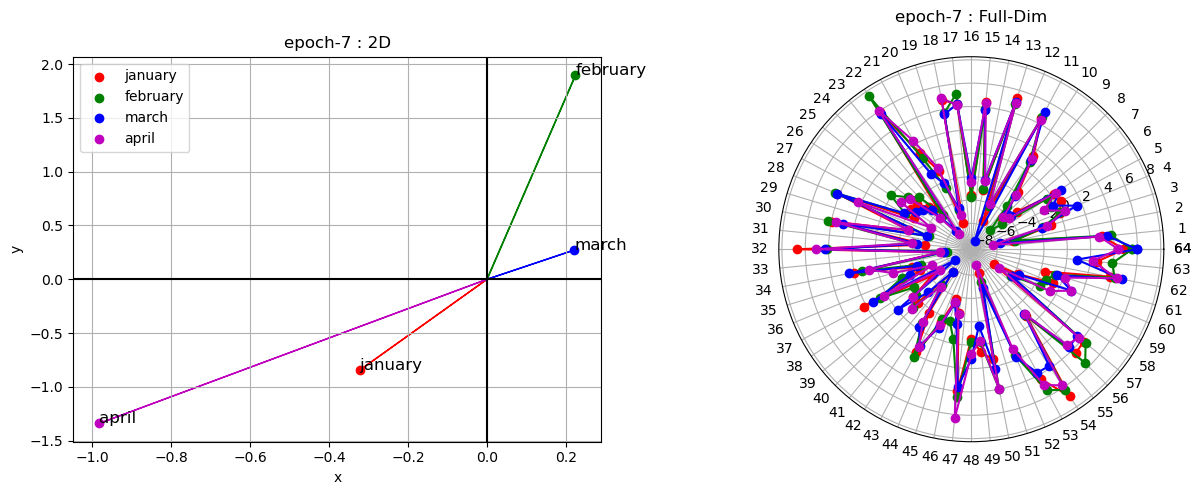

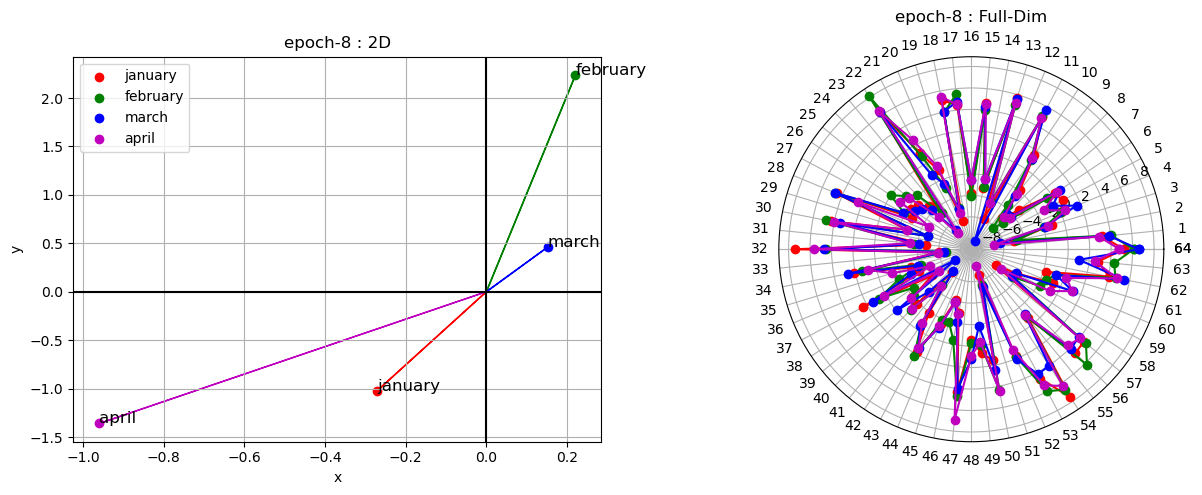

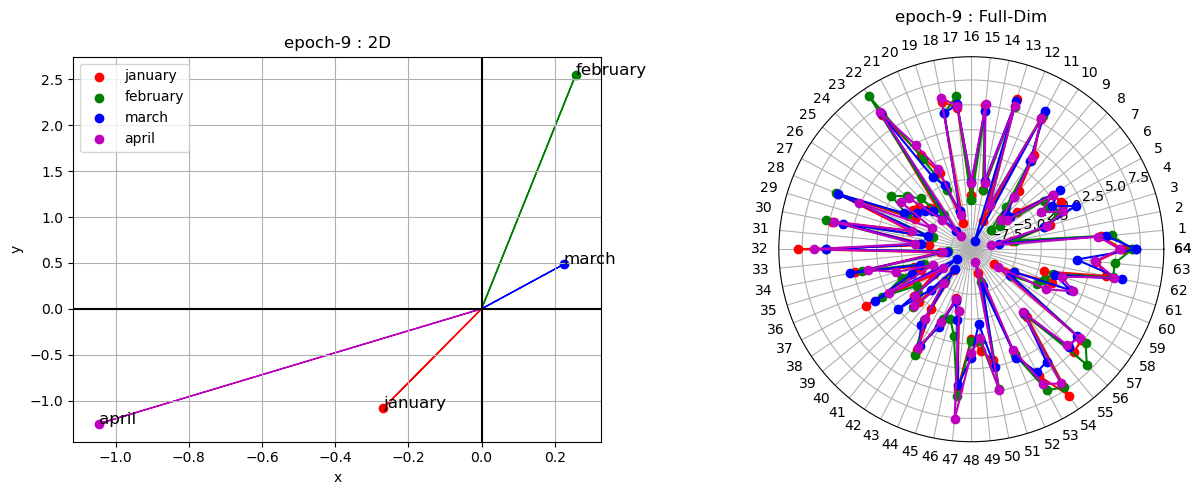

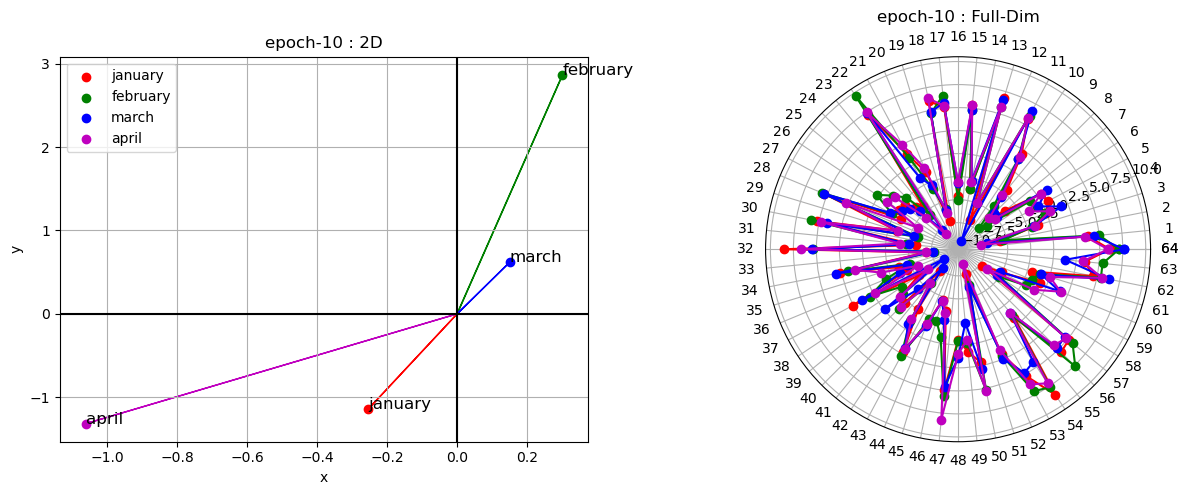

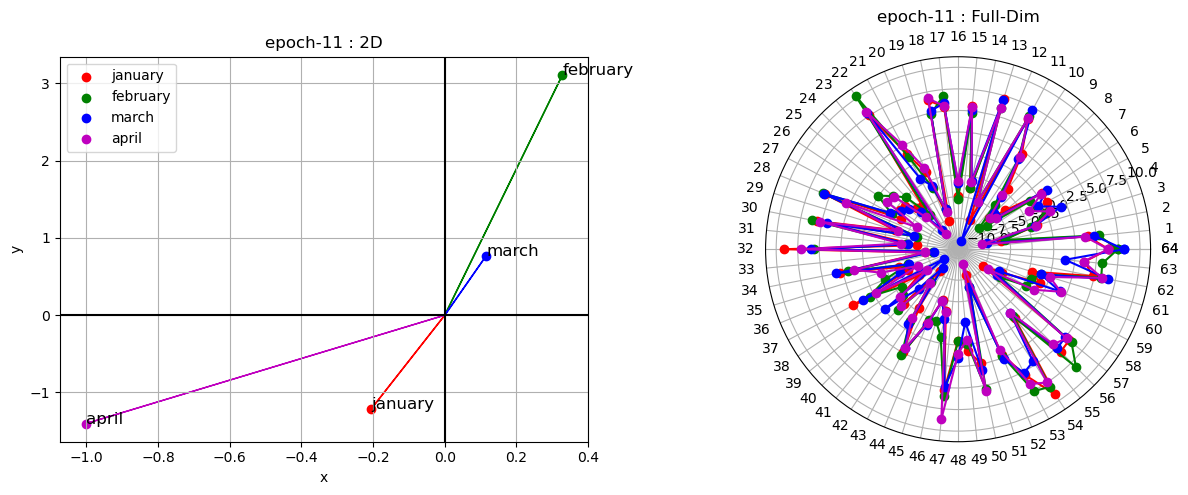

epoch-0 : 
cosine similarity between "january" and "february" is : -0.02007354237139225
cosine similarity between "january" and "march" is : -0.05507969483733177
cosine similarity between "january" and "april" is : 0.17283712327480316
-----------------------------------------
epoch-1 : 
cosine similarity between "january" and "february" is : 0.9582439064979553
cosine similarity between "january" and "march" is : 0.9639225006103516
cosine similarity between "january" and "april" is : 0.9533460736274719
-----------------------------------------
epoch-2 : 
cosine similarity between "january" and "february" is : 0.9569080471992493
cosine similarity between "january" and "march" is : 0.9537950158119202
cosine similarity between "january" and "april" is : 0.953522264957428
-----------------------------------------
epoch-3 : 
cosine similarity between "january" and "february" is : 0.9521641135215759
cosine similarity between "january" and "march" is : 0.9516729712486267
cosine similarity betw

In [208]:
# plot 2d embeddings for each epoch on the subplot1 and radius plot to show dimensionality on subplot2:
for epoch in range(num_epochs_random_w2v):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # plot the 2d
    ax1.set_title(f'epoch-{epoch+1} : 2D')
    for i in range(num_words_random_w2v):
        x, y = word_embeddings_2d_random_w2v[epoch, i]
        ax1.scatter(x, y, color=colors_w2v[i], label=test_words_132[i])
        ax1.arrow(0, 0, x, y, head_width=0.01, head_length=0.01, color=colors_w2v[i])
        ax1.text(x, y, test_words_132[i], fontsize=12)
    ax1.legend()
    ax1.grid(True)
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    ax1.axhline(y=0, color='k')
    ax1.axvline(x=0, color='k')
    # plot the radius plot
    # set ax2 as polar plot:
    ax2 = plt.subplot(1, 2, 2, projection='polar')
    ax2.set_title(f'epoch-{epoch+1} : Full-Dim')
    angles = np.linspace(0, 2*np.pi, embedding_dim_random_w2v, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    for i in range(num_words_random_w2v):
        Full_embedding = epochs_weights_list[epoch][i]
        Full_embedding = np.concatenate((Full_embedding, [Full_embedding[0]]))
        ax2.plot(angles, Full_embedding, "o-", color=colors_w2v[i], label=test_words_132[i])
    ax2.set_thetagrids(angles * 180/np.pi, labels=range(embedding_dim_random_w2v+1))
    ax2.grid(True)
    # show the plot:
    plt.show()
# compute similarity between "january" and other words in test_words_132 in each epoch:
for i in range(num_epochs_random_w2v):
    print(f'epoch-{i} : ')
    for j in range(num_words_random_w2v):
        if j != 0:
            print(f'cosine similarity between "january" and "{test_words_132[j]}" is : {cosine_similarity(epochs_weights_list[i][0], epochs_weights_list[i][j])}')
    print('-----------------------------------------')

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **1.4 [5 points] Learning phrases**
    
As per the original paper by [Mikolov et al](https://arxiv.org/abs/1301.3781) many phrases have a meaning that is not a simple composition of the meanings of their individual words.
For eg. `new york` is one entity, however, as per our analysis above, we have two separate entities `new` & `york` which can have different meanings independently.    
To learn vector representation for phrases, we first find words that
appear frequently together, and infrequently in other contexts.
    
As per the analysis in the paper, we can use a formula to rank commonly used word pairs, and take the first 100 commonly occurring pairs.
$$\operatorname{score}\left(w_{i}, w_{j}\right)=\frac{\operatorname{count}\left(w_{i} w_{j}\right)-\delta}{\operatorname{count}\left(w_{i}\right) \times \operatorname{count}\left(w_{j}\right)}$$

**NOTE:** For simplicity of analysis, we take the discounting factor $\delta$ as 0, and take bi-gram combinations. You can experiment with tri-grams for word pairs such as `New_York_Times`.     
    
</div>

**1.4.1** - Find 100 most common bi-grams

From the tokenized data above, find the count for each bigram pair.
    
For each such pair, find the score associated with each token pair using the formula above.
    
 Pick the top 100 pairs based on the score. (Higher the better). To understand the `score()` function we suggest you read the paper mentioned above.
    
Replace the original `text8` file with the pairs as one entity. E.g., if `prime, minister` is a commonly occurring pair, replace `... prime minister ...' in the original corpus with a single entity `prime_minister`. Do this for all 100 pairs.

In [88]:
# Get the training data again
filename = 'text8.zip'
with zipfile.ZipFile(filename) as f:
# Read the data into a list of strings.
    super_text = tf.compat.as_str(f.read(f.namelist()[0]))

In [96]:
# Fill in to complete this function
def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, oov_token='<UNK>')
    tokenizer.fit_on_texts(words)
    # Your code here
    # return tokenized sequence, word_counts, word_index, index_word:
    return tokenizer.texts_to_sequences(words), tokenizer.word_counts, tokenizer.word_index, tokenizer.index_word

In [97]:
# Make sure to use lower case and split as before
corpus = super_text.lower().split()
data, count, dictionary, reversed_dictionary = build_dataset(corpus,6000)

In [112]:
count["<UNK>"] = 0
# count 1s in data:
for i in range(len(data)):
    if data[i][0] == 1:
        count["<UNK>"] += 1
dictionary["<UNK>"] = 1
reverse_dictionary[1] = "<UNK>"

In [121]:
print(count["<UNK>"])
print(count["is"])

2449609
183153


In [122]:
index_counts = {dictionary[key] : val for key, val in count.items()}

In [123]:
print(data[:10])

[[5235], [3082], [13], [7], [196], [3], [3135], [47], [60], [157]]


In [185]:
bigram_counts = {}

In [153]:
def bigram_score(w1, w2):
    """Return the bigram score of a word pair."""
    return bigram_counts[(w1, w2)] / (index_counts[w1]*index_counts[w2])

In [154]:
print(corpus[:10])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [186]:
# Your code here
# Find bigram counts across data:
for i in range(len(data)-1):
    bigram = (data[i][0], data[i+1][0])
    if bigram in bigram_counts:
        bigram_counts[bigram] += 1
    else:
        bigram_counts[bigram] = 1
bigram_scores = {key : bigram_score(key[0], key[1]) for key in bigram_counts.keys()}
# sort bigram scores and get the 100 highest scoring bigrams:
sorted_bigram_scores = sorted(bigram_scores.items(), key=lambda x: x[1], reverse=True)
top_100_bigrams = sorted_bigram_scores[:100]
#append ("united", "kingdom") to top_100_bigrams:
top_100_bigrams.append(((dictionary["united"], dictionary["kingdom"]), bigram_scores[(dictionary["united"], dictionary["kingdom"])]))
#replace in text8.zip file the bigrams that are in the top 100 bigrams_list with a single token, eg "my friend" -> "my_friend":
for i in range(len(data)-1):
    bigram = (data[i][0], data[i+1][0])
    if bigram in [key for key, val in top_100_bigrams]:
        corpus[i] = reversed_dictionary[bigram[0]] + "_" + reversed_dictionary[bigram[1]]
        corpus[i+1] = ""
# remove empty strings from corpus:
corpus = [word for word in corpus if word != ""]



In [187]:
print(data[:10])
print((dictionary['united'],dictionary['kingdom']) in [key for key, val in top_100_bigrams])

[[5235], [3082], [13], [7], [196], [3], [3135], [47], [60], [157]]
True


In [188]:
print(bigram_counts[(dictionary['united'],dictionary['kingdom'])])
print(bigram_scores[(dictionary['united'],dictionary['kingdom'])])
print(top_100_bigrams[1])

2371
3.842728017286215e-05
((5056, 5338), 0.002350549520360841)


In [189]:
# display the top 100 bigrams:
for i in range(101):
    print(reversed_dictionary[top_100_bigrams[i][0][0]], reversed_dictionary[top_100_bigrams[i][0][1]])

costa rica
coca cola
fran ois
saudi arabia
monty python
ronald reagan
walt disney
elvis presley
infant mortality
hip hop
bipolar disorder
import insubstantial
amino acids
pearl harbor
mbox mbox
anglo saxon
blade runner
los angeles
equatorial guinea
hong kong
cosmic microwave
ms dos
adolf hitler
isaac asimov
julius caesar
westminster abbey
el salvador
stuart mill
carbon dioxide
anarcho capitalism
gregorian calendar
capita purchasing
serial killer
floppy disks
geographic coordinates
global warming
quarter finalist
super bowl
gamma rays
anglican communion
minimum wage
ron hubbard
imports commodities
mac os
mickey mouse
import jargon
colorado springs
http www
naturally occurring
nationality noun
hiv aids
evangelical lutheran
prize laureate
anarcho capitalist
rolling stones
commodities machinery
floppy disk
lambda calculus
telephones mobile
san francisco
monetary fund
jimmy carter
quantum mechanics
leon trotsky
big bang
tourist destination
symphony orchestra
fluid dynamics
fa cup
median inc

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**1.4.2** - Retrain word2vec   
With the new corpus generated as above, build the dataset, use skipgrams and retrain your word2vec with a sufficiently large vocabulary.

Write a function `most_dissimilar()`, similar to the `most_similar()` function, however this finds the top-n words which are **most dissimilar** to the given word.
Use this function defined above to find the entities most dissimilar to `united_kingdom`
    
Compare the above with separate tokens for `united` & `kingdom` and the sum of the vectors (to get this, you may need a sufficiently large vocabulary (>2000).
<br />

</div>

In [190]:
# Your code here

count_word_14 = {}

def build_dataset14(words, n_words):
    """Process raw inputs into a dataset."""
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=n_words, oov_token='<UNK>', filters='!"#$%&()*+,-./:;=?@[\\]^`{|}~\t\n', lower=True, split=' ', char_level=False)
    tokenizer.fit_on_texts(words)
    # Your code here
    # return tokenized data, count_word, count_id, word_to_id, id_to_word:
    return tokenizer.texts_to_sequences(words), tokenizer.word_counts, {tokenizer.word_index[key] : val for key, val in tokenizer.word_counts.items()}, tokenizer.word_index, tokenizer.index_word


In [191]:
vocab_size_14 = 3000
data_14, count_word_14, count_14, dictionary_14, reverse_dictionary_14 = build_dataset14(corpus, vocab_size_14)

In [192]:
# use tf.keras.preprocessing.sequence.skipgrams to build positive and negative samples for word2vec training
# window_size = 3
# Your code here:
sample_table_14 = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size_14)
couples_14, labels_14 = tf.keras.preprocessing.sequence.skipgrams(data_14, vocab_size_14, window_size=3, sampling_table=sample_table_14)

In [193]:
def build_model_w2v_14():
    embedding_dim = 64
    input_center = tf.keras.layers.Input(shape=(1,))
    input_context = tf.keras.layers.Input(shape=(1,))
    # shape of input_center: (None, 1)
    embedding_center = tf.keras.layers.Embedding(vocab_size_14 + 1, embedding_dim, input_length=1, name='embedding_center')(input_center)
    embedding_context = tf.keras.layers.Embedding(vocab_size_14 + 1, embedding_dim, input_length=1, name='embedding_context')(input_context)
    # shape of embedding_center: (None, 1, 64)
    # reshape to (None, 64):
    embedding_center = tf.keras.layers.Reshape((embedding_dim,))(embedding_center)
    embedding_context = tf.keras.layers.Reshape((embedding_dim,))(embedding_context)
    # shape of embedding_center: (None, 64)
    # Dot product of two tensors:
    dot_product = tf.keras.layers.Dot(axes=1, normalize=False)([embedding_center, embedding_context])
    # shape of dot_product: (None, 1)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dot_product)
    model = tf.keras.Model(inputs=[input_center, input_context], outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [194]:
for i in range(len(couples_14)):
    # if the element is a list return list[0] else return the element:
    if type(couples_14[i][0]) == list:
        couples_14[i][0] = couples_14[i][0][0]
    if type(couples_14[i][1]) == list:
        couples_14[i][1] = couples_14[i][1][0]

In [195]:
# split the couples into X_center and X_context:
couples_14 = np.array(couples_14, dtype = np.int32)
X_center = couples_14[:,0]
X_context = couples_14[:,1]
y_labels = np.array(labels_14, dtype = np.int32)
X_center = X_center.reshape(-1,1)
X_context = X_context.reshape(-1,1)
y_labels = y_labels.reshape(-1,1)

In [196]:
# train the model:
model_w2v_14 = build_model_w2v_14()
history_w2v_14 = model_w2v_14.fit([X_center, X_context], y_labels, epochs=3, batch_size=128, shuffle=True)



Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_center (Embedding)   (None, 1, 64)        192064      ['input_23[0][0]']               
                                                                                                  
 embedding_context (Embedding)  (None, 1, 64)        192064      ['input_24[0][0]']               
                                                                                           

Epoch 1/3
139338/139338 [==============================] - 366s 3ms/step - loss: 0.3539 - accuracy: 0.8460
Epoch 2/3
139338/139338 [==============================] - 299s 2ms/step - loss: 0.3332 - accuracy: 0.8559
Epoch 3/3
139338/139338 [==============================] - 286s 2ms/step - loss: 0.3281 - accuracy: 0.8584


In [214]:
# define a function to get the topn least similar words:
def most_dissimilar(word_embedding, embedding_matrix, k=10):
    """Returns the k least similar words to a given word."""
    # YOUR CODE HERE
    top_k = []
    row_matrix = embedding_matrix.shape[0]
    for i in range(row_matrix):
        ith_word_embedding = embedding_matrix[i]
        cosine_similarity_iw = cosine_similarity(ith_word_embedding, word_embedding)
        # if ith cosine similarity is greater than the last element of top_k, insert it in top_k and sort top_k then remove the last element:
        if len(top_k) < k:
            top_k.append((cosine_similarity_iw, i + 1))
            top_k.sort(key=lambda tup: tup[0])
        elif cosine_similarity_iw < top_k[-1][0]:
            top_k.append((cosine_similarity_iw, i + 1))
            top_k.sort(key=lambda tup: tup[0])
            top_k.pop()
    return top_k

In [199]:
# get the embedding_center layer weights:
embedding_layer_w2v_14 = model_w2v_14.get_layer('embedding_center')
weights_w2v_14 = embedding_layer_w2v_14.get_weights()[0]
# shape of weights_w2v_14: (vocab_size_14, embedding_dim)
words_14 = ["united_kingdom", "united", "kingdom"]
word_tokens_14 = [dictionary_14[word] for word in words_14]
word_embedding_14 = [weights_w2v_14[word_token] for word_token in word_tokens_14]
# append the sum of united and kingdom embedding:
word_embedding_14.append(word_embedding_14[1] + word_embedding_14[2])
words_14.append("united+kingdom")



In [215]:
# for each of the word in words_14, find the top 10 most dissimilar words:
for i in range(len(words_14)):
    word = words_14[i]
    tpo10_dissimilar_words = most_dissimilar(word_embedding_14[i], weights_w2v_14, 10)
    print("The top 10 most dissimilar words to {} are:".format(word))
    for j in range(10):
        print(f"{j+1}-th most dissimilar word to {word} is {reverse_dictionary_14[tpo10_dissimilar_words[j][1]]}")
    print("------------------------------------------")


The top 10 most dissimilar words to united_kingdom are:
1-th most dissimilar word to united_kingdom is <UNK>
2-th most dissimilar word to united_kingdom is constantinople
3-th most dissimilar word to united_kingdom is debate
4-th most dissimilar word to united_kingdom is wanted
5-th most dissimilar word to united_kingdom is carl
6-th most dissimilar word to united_kingdom is algorithms
7-th most dissimilar word to united_kingdom is cpu
8-th most dissimilar word to united_kingdom is capitalism
9-th most dissimilar word to united_kingdom is relative
10-th most dissimilar word to united_kingdom is performed
------------------------------------------
The top 10 most dissimilar words to united are:
1-th most dissimilar word to united is <UNK>
2-th most dissimilar word to united is constantinople
3-th most dissimilar word to united is capitalism
4-th most dissimilar word to united is suicide
5-th most dissimilar word to united is formation
6-th most dissimilar word to united is fifth
7-th mo

## **PART 2 [64 points]: IMDB Sentiment Analysis using ELMo**

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   
Sentiment analysis, also known as opinion mining or emotion AI, is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information.
    
For this part of the homework, we will be using the IMDB dataset, which is publicly available [here](http://ai.stanford.edu/~amaas/data/sentiment/).    

This represents a "many-to-one" problem, with the output classified as a `positive` or `negative` sentiment, depending on the words used in the review.
    
    
In the first part of this section, you are expected to build a language model to train a basic ELMo.
    
Although the original ELMo implementation uses *Character Embeddings*, for the sake of this homework, we will use word embeddings instead.
    
Read more about the ELMo paper [here](https://arxiv.org/pdf/1802.05365.pdf).

In the second part of this subsection, you will use the generated ELMo embeddings in a deep-learning model to perform sentiment analysis using the IMDB dataset.
    
You will compare its performance, with a baseline model without any trained embeddings, and another model which directly uses the `word2vec` embeddings.

<br />
    </div>

### **PART 2: Questions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

 **2.1 [15 points] Preprocess the dataset**
<br />

<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"
<br />

**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br /><br />
**2.1.3** Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.

</details>
<br />
    
**2.2 [34 points] Define and train the model**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  

**2.2.1** Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br>
<br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling
<br /><br />
    
**2.2.2** Building the language model
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.  

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**NOTE**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

**2.2.3** Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model  

</details>
    
<br />
    
 **2.3 [15 points] Transfer Learning**
    
<details>
<summary>
<font size="3" color="green">
<b>Click for instructions</b>
</font>
</summary>
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.
    
**2.3.1** - Baseline model:
    
For the baseline model, you will use:

- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

**2.3.2** - Directly using pre-trained `word2vec`:
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
    <br /><br />
**2.3.3** - You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.  

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.   

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$
    
Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.
</details>
</div>

### **PART 2: Solutions**    

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">



#### **2.1 [15 points] Preprocess the dataset**
</div>


**2.1.1** - Load the dataset

For simplicity, we will use the training split of the IMDB dataset.
- Limit to the most frequent 5000 words.
- Do not skip any frequently occurring words.
- Limit the largest review to a maximum of 200 words only.
    
    
**NOTE**: You can use the `imdb.get_word_index()` to get the mapping between tokens and words. This will load a dictionary with the mappings, which have to be corrected. A helper code is provided below to fix the dictionary.
    
Read more about `tf.keras.datasets.imdb` [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data?version=nightly).    
    
To each review, you must add an end-of-sentence token \<\/s>.

Eg. Review: "\<s\> This movie is so bad, I had to leave early"
    
Modified review: "\<s\> This movie is so bad, I had to leave early \<\/s\>"

In [450]:
# Read the data
# For simplicity, we will use the training split of the IMDB dataset.
# Limit to the most frequent 5000 words.
# Do not skip any frequently occurring words.
# Your code here
from keras.datasets import imdb
num_words = 5000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)


In [451]:
print(type(train_data))
print(train_data.shape)
print(train_data[0])
print(train_labels[0])
print(test_data.shape)
print(test_data[0])

<class 'numpy.ndarray'>
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1
(25000,)
[1, 591, 202, 14, 31, 6, 717, 1

In [452]:
# Your code here
### Helper code to fix the mapping of the imdb word index

index = tf.keras.datasets.imdb.get_word_index()

# we need to add 3 from the indices because 0 is 'padding', 1 is 'start of sequence' and 2 is 'unknown'

inv_index = {j+3:i for i,j in index.items()}

# Tags for start and end of sentence

inv_index[1] = '<s>'
inv_index[2] = 'UNK'
inv_index[3] = '</s>'

index = {j:i for i,j in inv_index.items()}

In [453]:
print(type(index))
print(len(index))
print(len(inv_index))

<class 'dict'>
88587
88587


In [454]:
# append 3 </s> to the end of every data point in the training and test sets:
for i in range(len(train_data)):
    train_data[i].append(3)
for i in range(len(test_data)):
    test_data[i].append(3)

In [455]:
print(train_data[0])
print(train_data[1])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32, 3]
[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8,

In [456]:

# Limit the largest review to a maximum of 200 words only.
max_length = 200
train_mask_len200 = [len(x) <= max_length for x in train_data]
train_data = train_data[train_mask_len200]
train_labels = train_labels[train_mask_len200]
test_mask_len200 = [len(x) <= max_length for x in test_data]
test_data = test_data[test_mask_len200]
test_labels = test_labels[test_mask_len200]


In [457]:
print(train_data.shape)
print(test_data.shape)

(14244,)
(14669,)


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.1.2** - Load the `word2vec` embeddings
    
You will use the pre-trained `word2vec` embeddings for this section of the homework. This file can be downloaded from [here](https://github.com/dlops-io/datasets/releases/download/v1.0/GoogleNews-vectors-negative300.bin.gz) and can be accessed like a dictionary.
    
**NOTE**: To access the pre-trained embeddings, [gensim](https://pypi.org/project/gensim/) library can be used.

Check if the embeddings for the start token (\<s\>) and end token (\</s\>) are present in the loaded `word2vec` embeddings.

Add the \<s\> and\</s\> tokens to the `word2vec` embeddings as random vectors if they are not present.

Create an `embedding_matrix` that will consist of the words present in word2vec. It will be a matrix of dimension `num_words X embedding_dim` `(5000 X 300)` including the addition of start and end tokens.
<br />

</div>

In [242]:
pip install gensim

                                              0.0/24.0 MB ? eta -:--:--
                                              0.0/24.0 MB ? eta -:--:--
                                             0.0/24.0 MB 435.7 kB/s eta 0:00:55
                                              0.1/24.0 MB 1.1 MB/s eta 0:00:23
                                              0.2/24.0 MB 1.1 MB/s eta 0:00:22
                                              0.3/24.0 MB 1.5 MB/s eta 0:00:17
                                              0.4/24.0 MB 1.4 MB/s eta 0:00:17
                                              0.5/24.0 MB 1.8 MB/s eta 0:00:14
     -                                        0.7/24.0 MB 2.0 MB/s eta 0:00:12
     -                                        1.0/24.0 MB 2.4 MB/s eta 0:00:10
     --                                       1.2/24.0 MB 2.8 MB/s eta 0:00:09
     --                                       1.3/24.0 MB 2.6 MB/s eta 0:00:09
     --                                       1.5/24.0 MB 3.0 MB/

In [458]:
# Obtaining Word2Vec embeddings using gensim library
import gensim.downloader as api

model = api.load("word2vec-google-news-300")


In [459]:
# add <s> and </s> to the vocabulary as random vectors:
vector_size = model.vector_size
# create random start and end vectors
random_vector_start = np.random.rand(vector_size)
random_vector_end = np.random.rand(vector_size)
# create an embedding_matrix_gensim:
embedding_matrix_gensim = np.zeros((num_words, vector_size))
embedding_matrix_gensim[0] = random_vector_start
embedding_matrix_gensim[2] = random_vector_end
embedding_matrix_gensim[1] = model["UNK"]
for word, ind in index.items():
    if ind >= num_words:
        continue
    if ind <= 3:# for 1, 2, 3 we have already assigned vectors
        continue
    try:
        embedding_vector = model[word]
        embedding_matrix_gensim[ind - 1] = embedding_vector
    except KeyError:
        embedding_matrix_gensim[ind - 1] = model["UNK"]


In [460]:
print(type(model))
tmp_word = 'mouse'
tmp_word1 = 'rat'
tmp_embedding = model[tmp_word]
tmp_embedding1 = model[tmp_word1]
similarity_tmp = model.similarity(tmp_word, tmp_word1)
print(tmp_embedding.shape)
#print(tmp_embedding)
print(similarity_tmp)
tmp_word2 = "UNK"
tmp_embedding2 = model[tmp_word2]
print(tmp_embedding2.shape)
print(model.key_to_index[tmp_word2])

<class 'gensim.models.keyedvectors.KeyedVectors'>
(300,)
0.4651036
(300,)
98307


In [461]:
print(embedding_matrix_gensim.shape)

(5000, 300)


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
        
    
**2.1.3** - Prepare data for model training:

- Not all the words in the reviews are present in the embeddings file. Hence, if it is not present, you must OMIT that word from the sentence.
   
E.g. If `and` token is not present in the embeddings:
   
```
OLD SENTENCE: <s>The movie was good and I really liked it </s>
    
NEW SENTENCE: <s> The movie was good I really liked it </s>
    
```

- Split the data (`x_train` (tokens list), `y_train` (class list)) into 80% training and 20% validation. We will use the `y_train` (which is the sentiment associated with each movie review) only in Part 2.3 for sentiment analysis.
</div>

In [462]:
print(train_data[0])
print(type(train_data[0]))
print(type(train_data))

[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 2, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 2, 5, 163, 11, 3215, 2, 4, 1153, 9, 194, 775, 7, 2, 2, 349, 2637, 148, 605, 2, 2, 15, 123, 125, 68, 2, 2, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 2, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 2, 5, 2, 656, 245, 2350, 5, 4, 2, 131, 152, 491, 18, 2, 32, 2, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95, 3]
<class 'list'>
<class 'numpy.ndarray'>


In [463]:
# Your code here
# traverse the train_data and test_data, and if token is not present in the embedding, remove it from the data:
for i in range(len(train_data)):
    for j in range(len(train_data[i])):
        word_token = train_data[i][j]
        if word_token >= num_words:
            # delete the word from the train_data:
            train_data[i].remove(train_data[i][j])
# traverse the test_data:
for i in range(len(test_data)):
    for j in range(len(test_data[i])):
        word_token = test_data[i][j]
        if word_token >= num_words:
            # delete the word from the test_data:
            test_data[i].remove(test_data[i][j])

In [464]:
# split train_data and train_labels into train and validation sets with 80/20 split:
tokens_list_train, tokens_list_val, labels_train, labels_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
#### **2.2 [34 points] Define and train the model**
    
We define an *ELMo-like* language model using bi-directional LSTMs and residual connections  **without** the character CNN to simplify the analysis.
    
We will use the `word2vec` embeddings instead of the character representations of the CNN.
    
For simplicity, we train our *ELMo-like* language model on the IMDB dataset itself. But generally, language models are trained on much larger corpora.  
</div>


**2.2.1** - Build a `tf.data.Dataset` for training, and another one for validation

- Set an appropriate batch size (32, 64, 128, 256,...) This value will be determined by the GPU you have.

- Set `train_shuffle_buffer_size` and `validation_shuffle_buffer_size` to the length of training data and validation data respectively

- `tf.data.Dataset` is an efficient way to build data pipelines. Instead of preprocessing the entire dataset, we can preprocess a batch. It is faster and consumes fewer resources, which is optimal for training.

- Hint: When creating tf.data.Dataset use `tf.ragged.constant` to convert your ragged tokens to ragged tensors

- `dataset.map` enable us to apply a function to each element of the batch individually. The parameter `num_parallel_calls` allow us to control how many threads we will use to feed the network. It can be set to `num_parallel_calls=AUTOTUNE`. You will use the `transform_pad` function to perform model-specific data processing.

- When building the tf.data pipeline use the following order:
  - shuffle
  - batch
  - map
  - prefetch
<br><br>
- After you build your train and validation dataset, use `dataset.take(1)` to view the first row of data from the training dataset. It is important to verify the data input and output dimensions before modelling

In [469]:
# Helper Code
batch_size = 64
train_shuffle_buffer_size = len(tokens_list_train)
validation_shuffle_buffer_size = len(tokens_list_val)

# Fill the required cells to complete the function
def transform_pad(input, output,n):

    # You will  transform the input at the run time
    input = input.to_tensor(default_value=0, shape=[None, None])
    # get the shape of the input:
    shape = tf.shape(input)
    # build the inputs_forward and inputs_backward:
    mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 3))(input)
    inputs_forward = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([input, mask])
    inputs_forward = tf.reshape(inputs_forward, shape=(-1, shape[1]-1))
    mask = tf.keras.layers.Lambda(lambda x: tf.math.not_equal(x, 1))(input)
    inputs_backward = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([input, mask])
    inputs_backward = tf.reshape(inputs_backward, shape=(-1, shape[1]-1))
    # Transform the output for the f and b LSTM
    output_f = output[:,1:]
    output_b = output[:,:-1]


    # Pad the outputs
    output_f = output_f.to_tensor(default_value=0, shape=[None, None])
    output_b = output_b.to_tensor(default_value=0, shape=[None, None])

    return (inputs_forward, inputs_backward),(output_f, output_b)

# Calculate and store length of each sentence
N_train = [[len(n)] for n in tokens_list_train]
N_val = [[len(n)] for n in tokens_list_val]

N_train = tf.constant(N_train, tf.int32)
N_val = tf.constant(N_val, tf.int32)

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(tokens_list_train)
validate_processed_x = tf.ragged.constant(tokens_list_val)
train_processed_y = tf.ragged.constant(tokens_list_train)
validate_processed_y = tf.ragged.constant(tokens_list_val)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y,N_train))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y,N_val))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(transform_pad, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>
validation_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)), (TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)))>


In [470]:
# View some data from tf dataset
for (input_f,input_b) ,(output_f, output_b) in train_data.take(1):
  print(input_f.shape)
  print(input_f[0])
  print(input_b.shape)
  print(input_b[0])
  print("************************")
  print(output_f.shape,output_b.shape)
  print(output_f[0])
  print(output_b[0])

(64, 199)
tf.Tensor(
[   1   14    9    6   52  463    6   22   15   11 2716    7    4  364
  675    9   53   74  290  149    4   65    9 1728    5   12  152  193
  196  159    4 1175  200    2    2    5 1022 3512    2  129  692    4
  116    9   86  707    5    4  105   26 4359   73  518   12  764   40
    4  167  426 1197  309  200  453    5  731  212 1022    2 1146    7
    4 1164    2    5 3566    2   19 1509  590 1983    2 1599   11    4
 4094 2126  958    7  388   18  919   17  127    4  168   11    2    2
  523   54   59    9 3991  308   27   86 1296    7    2   11    6  196
   58   85  211    4  156    5  262    2    2  202   14  212  179    2
    6  905    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.2.2** - Building the language model ELMO with word embedding instead of char basis
    
*Transform Input within the model:*

*   In forward LSTM, we use the n-th token to predict the (n+1)-th token. Hence we want to discard the last one, the end of sentence token, `</s>`, from all the sentences. Remember all the sentences are padded, so the `</s>` will not be the last element of the sequence.

   * One way of achieving that is, using a Boolean mask with help of [tf.sequence_mask](https://www.tensorflow.org/api_docs/python/tf/sequence_mask) or with the help of [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd), which can be used to select specific elements from a tensor based on their indices. Remember you can combine multiple boolean masks via multiple logic operations. We also encourage you to come up with your solutions.
   * Note that after using boolean masks your outputs will be flattened out and you have to reshape them back with the appropriate batch size. Remember that you removed the end of sentence token, hence the length of the sequence would be length-1.

    
![](https://drive.google.com/uc?export=view&id=1f5bPplDGlRUdfii5X1bD2kd20SKRyOSo)
  

* For the backward LSTM layers, the next word prediction task is doing the reverse of what it was doing for the forward LSTM layers. We aim to predict the n-th token with the (n+1)-th token. To achieve this we remove the start of the sentence token `<s>` from all the sentences.


The model's inputs should be followed by a `tf.keras.layers.Embedding()` layer. The `Embedding` layer will act as a lookup table to convert token inputs to their corresponding word2vec values. When initialising the `Embedding` layer, set the layer weights with the `embedding_matrix` you had built in the previous question.

Set the trainable to false and mask_zero to true in the `Embedding` layer. The input dimension should be the number of rows in `embedding_matrix` and the output dimension should be your embedding dimension of `300`.
    
Refer to this image from the lecture slides on ELMo.
    
    
![](https://drive.google.com/uc?export=view&id=1fNPnrBR7Wfh_Jci70QaHde1L3nTcs9-D)
    
*go_backwards in backward LSTM layers*

* To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it. Refer to the documentation of [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Remember to invert the sequence dimension and not the embedding dimension.

Remember to use the **same** *softmax* layer on both the forward and the backward LSTMs.
    
This will give you an `output_f` and `output_b` which you will evaluate with your two targets.     

$$L = -\sum y \cdot log(\widehat{y}_{right}) -\sum y \cdot log(\widehat{y}_{left})$$

Use an appropriate loss function, and optimizer and train the network sufficiently.   

Finally, plot the training history of the train and validation loss.
<br />
    
**Note**: Use native tensorflow functions like `tf.shape` instead of numpy functions like `np.shape`.
<br />  

</div>    

In [471]:
# Your code here
num_words, embedding_dim = embedding_matrix_gensim.shape
print(num_words, embedding_dim)
hidden_dim = embedding_dim//2
def build_ELMo_model():
    input_f = tf.keras.layers.Input(shape=(None,))
    input_b = tf.keras.layers.Input(shape=(None,))

    Emb_layer = tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim, mask_zero=True, weights=[embedding_matrix_gensim], trainable=False, name='ELMo_Embedding', input_length=None)
    emb_forward = Emb_layer(input_f)
    # shape of emb_forward: (batch_size, seq_len-1, embedding_dim)
    emb_backward = Emb_layer(input_b)
    # shape of emb_backward: (batch_size, seq_len-1, embedding_dim)

    # define double BiLSTM layers for forward sequence:
    # forward LSTM:
    LSTM_f1 = tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True, name = 'LSTM_f1')
    # LSTM_f1 takes the input of shape (batch_size, seq_len-1, embedding_dim)
    hidden_f1 = LSTM_f1(emb_forward)
    # shape of hidden_f1: (batch_size, seq_len-1, hidden_dim)
    W_f1 = tf.keras.layers.Dense(units=hidden_dim, activation='ReLU', use_bias=False, name = 'ResNet_W_f1')
    protected_f1 = W_f1(emb_forward)
    # shape of protected_f1: (batch_size, seq_len-1, hidden_dim)
    residual_f1 = tf.keras.layers.Add(name="f1_ADD")([hidden_f1, protected_f1])
    # shape of residual1: (batch_size, seq_len-1, hidden_dim)
    LSTM_f2 = tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True, name = 'LSTM_f2')
    hidden_f2 = LSTM_f2(residual_f1)
    # shape of hidden_f2: (batch_size, seq_len-1, hidden_dim)
    
    # define double BiLSTM layers for backward sequence:
    # backward LSTM:
    # To predict the words backwards, we will use the go_backwards parameter present in the TensorFlow LSTM layer implementation. Remember to reverse the output of each backward LSTM layer before using it.
    LSTM_b1 = tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True, go_backwards=True, name = 'LSTM_b1')
    hidden_b1 = LSTM_b1(emb_backward)
    # shape of hidden_b1: (batch_size, seq_len-1, hidden_dim)
    # reverse hidden_b1 in the seq_len dimension:
    hidden_b1 = tf.reverse(hidden_b1, axis=[1])
    # before reverse, hidden_b1 is in reverse time order, after reverse, hidden_b1 is in normal time order
    W_b1 = tf.keras.layers.Dense(units=hidden_dim, activation='ReLU', use_bias=False, name = 'ResNet_W_b1')
    protected_b1 = W_b1(emb_backward)
    # shape of protected_b1: (batch_size, seq_len-1, hidden_dim)
    residual_b1 = tf.keras.layers.Add(name = "b1_ADD")([hidden_b1, protected_b1])
    LSTM_b2 = tf.keras.layers.LSTM(units=hidden_dim, return_sequences=True, go_backwards=True, name = 'LSTM_b2')
    hidden_b2 = LSTM_b2(residual_b1)
    # shape of hidden_b2: (batch_size, seq_len-1, hidden_dim)
    # reverse hidden_b2 in the seq_len dimension:
    hidden_b2 = tf.reverse(hidden_b2, axis=[1])
    # before reverse, hidden_b2 is in reverse time order, after reverse, hidden_b2 is in normal time order
    # Define a Dense layer with softmax activation for predicting the next word:
    dense_layer = tf.keras.layers.Dense(units=num_words, activation='softmax', name='ELMo_output')
    output_forward = dense_layer(hidden_f2)
    output_backward = dense_layer(hidden_b2)
    # shape of output_forward and output_backward: (batch_size, seq_len-1, num_words)
    # build the model:
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
    model = tf.keras.models.Model(inputs=[input_f, input_b], outputs=[output_forward, output_backward])
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    # get weights of the embedding layer:
    weights_word2vec = tf.keras.layers.Lambda(lambda x: x[:,1:,:])(emb_forward)
    weights_hidden1 = tf.keras.layers.Concatenate(axis=2)([hidden_f1[:,1:,:], hidden_b1[:,:-1,:]])
    weights_hidden2 = tf.keras.layers.Concatenate(axis=2)([hidden_f2[:,1:,:], hidden_b2[:,:-1,:]])
    
    model_api = tf.keras.models.Model(inputs=[input_f, input_b], outputs=[weights_word2vec, weights_hidden1, weights_hidden2])
    return model, model_api




5000 300


In [472]:
# train the model:
model_ELMo, Toy_EMLo = build_ELMo_model()
# fit the model dataset train_data:
Early_stopping_ELMo = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_ELMo = model_ELMo.fit(train_data, epochs=100, validation_data=validation_data, callbacks=[Early_stopping_ELMo])

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_144 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 input_145 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 ELMo_Embedding (Embedding)     (None, None, 300)    1500000     ['input_144[0][0]',              
                                                                  'input_145[0][0]']              
                                                                                                  
 LSTM_b1 (LSTM)                 (None, None, 150)    270600      ['ELMo_Embedding[1][0]']  

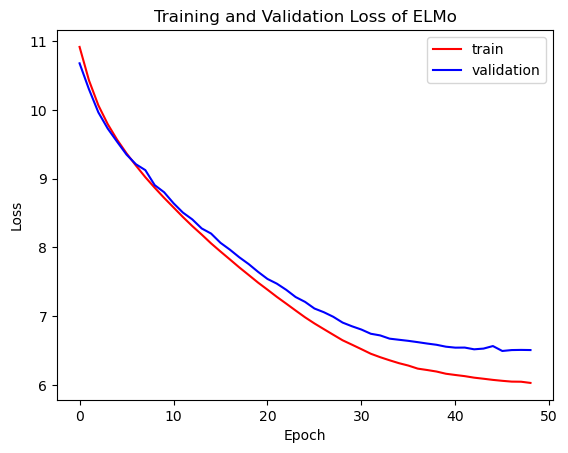

In [473]:
# plot the structure of the model:
tf.keras.utils.plot_model(model_ELMo, show_shapes=True, dpi=90)
plt.show()
# plot the training history of the train and validation loss
plt.plot(range(len(history_ELMo.history['loss'])),history_ELMo.history['loss'], label='train', color='red')
plt.plot(range(len(history_ELMo.history['val_loss'])),history_ELMo.history['val_loss'], label='validation', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of ELMo')
plt.legend()
plt.show()

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
   

**2.2.3** - Extracting ELMo embeddings
    
Use the Functional API to build another model called `Toy_ELMo` to obtain the embeddings.

*To concatenate the forward and backward LSTM hidden states we have to align them, which will be achieved by removing the start and end of sentence token embeddings from the forward and the backwards LSTM hidden states respectively. You can use the same logic that you used to process the input. It is necessary to reverse the output of the backward LSTM layers before using it in the Toy ELMo model.*

The obtained embeddings should be:
    
1. The `word2vec` embeddings
        
    This is just the output after the masked layer in the language model defined above.    
    
2. The first bidirectional-LSTM layer embeddings

    This will be the concatenation of the first LSTM layers of the language model (`lstm1 forward + lstm1 backwards`).
    
3. The second bidirectional-LSTM layer embeddings

    This will be the concatenation of the second LSTM layer of the language model (`lstm2 forward + lstm2 backwards`).    
    
- Make a test prediction of your `Toy_ELMo` model    

</div>    

In [491]:
Toy_EMLo.summary()
# set Toy_EMLo as non-trainable:
Toy_EMLo.trainable = False

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_144 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 input_145 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 ELMo_Embedding (Embedding)     (None, None, 300)    1500000     ['input_144[0][0]',              
                                                                  'input_145[0][0]']              
                                                                                                  
 LSTM_b1 (LSTM)                 (None, None, 150)    270600      ['ELMo_Embedding[1][0]']  

In [492]:
# test prediction of Toy_ELMo:
for (input_f,input_b) ,(output_f, output_b) in train_data.take(1):
    weights_w2v, weights_h1, weights_h2 = Toy_EMLo([input_f, input_b])
    print(weights_w2v.shape)
    print(weights_w2v[0])
    print("#####################")
    print(weights_h1.shape)
    print(weights_h1[0])
    print("#####################")
    print(weights_h2.shape)
    print(weights_h2[0])
    print("#####################")

(64, 198, 300)
tf.Tensor(
[[ 0.00704956 -0.07324219  0.171875   ...  0.01123047  0.1640625
   0.10693359]
 [-0.14453125  0.06787109 -0.09667969 ... -0.3984375  -0.04125977
   0.1328125 ]
 [-0.01574707 -0.02832031  0.08349609 ...  0.00686646  0.06103516
  -0.1484375 ]
 ...
 [ 0.8751065   0.47243753  0.7681363  ...  0.60966265  0.41153663
   0.25774115]
 [ 0.8751065   0.47243753  0.7681363  ...  0.60966265  0.41153663
   0.25774115]
 [ 0.8751065   0.47243753  0.7681363  ...  0.60966265  0.41153663
   0.25774115]], shape=(198, 300), dtype=float32)
#####################
(64, 198, 300)
tf.Tensor(
[[-0.44898924  0.07955772 -0.36148286 ...  0.19311726 -0.4907796
   0.28542918]
 [-0.28128746  0.01201204 -0.22220762 ...  0.05580153 -0.77117753
   0.4673087 ]
 [-0.34104532  0.22438213 -0.12848386 ...  0.12426002 -0.21676362
  -0.5713351 ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.   

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

#### **2.3 [15 points] Transfer Learning**
    
Once you've sufficiently trained your ELMo embeddings, we can use it for a downstream task such as sentiment analysis.

</div>    

**2.3.1** - Baseline model
    
For the baseline model, you will use:
    
- `tf.keras.Layers.Embedding()` layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer
    
You will build a `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). Unlike in 2.2.1 we only need a single sequence of tokens for this model

Train it for sufficient epochs using an appropriate optimizer and learning rate.

In [411]:
# build dataset with target as only a class pos/neg:
batch_size = 64
train_shuffle_buffer_size = len(tokens_list_train)
validation_shuffle_buffer_size = len(tokens_list_val)

# build baseline dataset:
train_processed_x_baseline = train_processed_x.to_tensor(default_value=0, shape=[None, None])
validate_processed_x_baseline = validate_processed_x.to_tensor(default_value=0, shape=[None, None])
train_data_baseline = tf.data.Dataset.from_tensor_slices((train_processed_x_baseline, labels_train))
validation_data_baseline = tf.data.Dataset.from_tensor_slices((validate_processed_x_baseline, labels_val))

# apply all data processing logic
train_data_baseline = train_data_baseline.shuffle(buffer_size=train_shuffle_buffer_size)
train_data_baseline = train_data_baseline.batch(batch_size)
train_data_baseline = train_data_baseline.prefetch(AUTOTUNE)
# apply all data processing logic
validation_data_baseline = validation_data_baseline.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data_baseline = validation_data_baseline.batch(batch_size)
validation_data_baseline = validation_data_baseline.prefetch(AUTOTUNE)

print(train_data_baseline)
print(validation_data_baseline)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 200), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [412]:
# Your code here
# build a baseline_model:
def build_baseline_model():
    # embedding->2 layers of GRU->Dense->output
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=num_words, output_dim=embedding_dim))
    # GRU:
    model.add(tf.keras.layers.GRU(units=32, return_sequences=True))
    model.add(tf.keras.layers.GRU(units=32))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # compile:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [413]:
model_baseline = build_baseline_model()
history_baseline = model_baseline.fit(train_data_baseline, epochs=10, validation_data=validation_data_baseline, verbose=0)

In [417]:
print(history_baseline.history['val_accuracy'])

[0.5159705281257629, 0.5959985852241516, 0.8195858001708984, 0.854334831237793, 0.8434538245201111, 0.8522288799285889, 0.85012286901474, 0.8515268564224243, 0.8522288799285889, 0.8441558480262756]


<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">

**2.3.2** - Directly using pre-trained `word2vec`
    
For this section, use the pre-trained `word2vec` embeddings directly into your model.

You can use the same `tf.data.Dataset` from 2.3.1 for this model
    
Train, and compare its performance with the baseline model defined above **using the same architecture** as above.
</div>

In [423]:
# build a baseline_model:
def build_baseline_model_pre(embedding_Matrix):
    # embedding->2 layers of GRU->Dense->output
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=embedding_Matrix.shape[0], output_dim=embedding_Matrix.shape[1], weights=[embedding_Matrix], trainable=False))
    # GRU:
    model.add(tf.keras.layers.GRU(units=32, return_sequences=True))
    model.add(tf.keras.layers.GRU(units=32))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    # compile:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [424]:
# Your code here
model_pre_w2v = build_model_w2v()
model_pre_w2v.load_weights("model_w2v.h5")
embedding_center_matrix_pre = model_pre_w2v.get_layer('embedding_center').get_weights()[0]
model_pre_baseline = build_baseline_model_pre(embedding_center_matrix_pre)
# train the model:
history_pre_baseline = model_pre_baseline.fit(train_data_baseline, epochs=10, batch_size=128, validation_data=validation_data_baseline)

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_128 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 input_129 (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 embedding_center (Embedding)   (None, 1, 64)        192064      ['input_128[0][0]']              
                                                                                                  
 embedding_context (Embedding)  (None, 1, 64)        192064      ['input_129[0][0]']              
                                                                                           

Trainable params: 384,130
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
179/179 [==============================] - 6s 25ms/step - loss: 0.6942 - accuracy: 0.4925 - val_loss: 0.6938 - val_accuracy: 0.4935
Epoch 2/10
179/179 [==============================] - 4s 22ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6939 - val_accuracy: 0.4914
Epoch 3/10
179/179 [==============================] - 4s 22ms/step - loss: 0.6929 - accuracy: 0.5067 - val_loss: 0.6933 - val_accuracy: 0.5121
Epoch 4/10
179/179 [==============================] - 4s 23ms/step - loss: 0.6918 - accuracy: 0.5080 - val_loss: 0.6942 - val_accuracy: 0.5160
Epoch 5/10
179/179 [==============================] - 4s 23ms/step - loss: 0.6904 - accuracy: 0.5015 - val_loss: 0.6935 - val_accuracy: 0.5146
Epoch 6/10
179/179 [==============================] - 4s 23ms/step - loss: 0.6874 - accuracy: 0.5057 - val_loss: 0.6916 - val_accuracy: 

<div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA">
    
**2.3.3** You have already done sentiment analysis using `tf.keras.layers.Embedding()`. You will now aim to beat that baseline using your ELMo embeddings.

Using ELMo embeddings:

You will build another `tf.data.Dataset` similar to the one created in Section 2.2.1 but instead of having a target as a series of tokens, the target should only be a class (positive or negative sentiment). This model also requires two inputs one for forward and one for backward LSTM.

For this model, you will use:
- `Toy_ELMo` model after the input layer
-  Sauce layer
-  2 layers of `GRU` with `hidden_size=300`
-  Dense output layer

**NOTE**: Set `Toy_ELMo.trainable` to `False` to avoid retraining the model.
        
Create the **sauce** layer to combine the three embeddings from your `Toy_ELMo`. You should have **three** trainable parameters in this layer

$$ELMo_{t} = \gamma \sum_{j=0}^{L} s_{j} h_{t}^{j}$$

Since we are not using any other embeddings, we will set the value of $\gamma$ to 1. <br>
Train the modified model sufficiently, and compare it to the previously trained models.

</div>  

In [478]:
# Helper code
# Scale layer for sauce
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ScaleLayer, self).__init__()
        self.supports_masking = True
        self.shape = shape

    def build(self, inputs):
        sauce_initializer = tf.keras.initializers.Constant(value = [0.4, 0.3, 0.3])
        self.scale = self.add_weight(shape = (self.shape,), initializer = sauce_initializer, trainable = True)

    def call(self, inputs):
        scale_norm = tf.nn.softmax(self.scale)

        return tf.tensordot(scale_norm, inputs, axes=1)

In [498]:
def transform_fb(inputs, outputs):
    # build forward input:
    shape = tf.shape(inputs)
    mask = tf.keras.layers.Lambda(lambda x: tf.not_equal(x, 3))(inputs)
    forward_seq = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([inputs, mask])
    forward_seq = tf.reshape(forward_seq, shape=(-1, shape[1]-1))
    # build backward input:
    mask = tf.keras.layers.Lambda(lambda x: tf.not_equal(x, 1))(inputs)
    backward_seq = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([inputs, mask])
    backward_seq = tf.reshape(backward_seq, shape=(-1, shape[1]-1))
    return (forward_seq, backward_seq), outputs

train_data_233 = train_data_baseline.map(transform_fb, num_parallel_calls=AUTOTUNE)
validation_data_233 = validation_data_baseline.map(transform_fb, num_parallel_calls=AUTOTUNE)
print(train_data_233)
print(validation_data_233)


<ParallelMapDataset element_spec=((TensorSpec(shape=(None, 199), dtype=tf.int32, name=None), TensorSpec(shape=(None, 199), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<ParallelMapDataset element_spec=((TensorSpec(shape=(None, 199), dtype=tf.int32, name=None), TensorSpec(shape=(None, 199), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [501]:
for (input_f, input_b), output_y in train_data_233.take(1):
    print(input_f[0])
    print(input_b[0])
    print(output_y[0])

tf.Tensor(
[   1  575  725    6 1039    7   14   24 1923    5   48   13   69 1084
   61  205  278   23   14  474   30 1556  148 1893    5    2   12  145
   32   13   70  135    9   14   62   30    6  394 1475   22  101 1897
    7    4 3449    7   22    9 4948  116    9  558  373    4   65   62
   28   77    2   39    4  204 4754 3254  201   17 4981    5  835    5
    4  653   11 1163    7    4  485 1730 2097    8    4    2    9 1322
   10   10   13   70   64 1041   15    4    2  857    7   14   22   26
   39  369    5  223  146 1595   45   24   60    2   78   10   10 2374
   11    4 1572   10   10  798  798  798    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [502]:
# define a new model with layers:Toy_ELMo, Sauce layer, 2 layers of GRU with hidden_size=300, Dense output layer
def Sauce_ELMo_model(Toy_ELMo):
    inputs_forward = tf.keras.layers.Input(shape=(None,))
    inputs_backward = tf.keras.layers.Input(shape=(None,))
    # Toy_ELMo layer
    weights = Toy_ELMo([inputs_forward, inputs_backward])
    # shape of weights: (batch_size, 3, seq_len, 300)
    # Sauce layer
    scale_layer = ScaleLayer(shape=3)
    sauced_weight = scale_layer(weights)
    # shape of sauced_weight: (batch_size, seq_len, 300)
    # 2 layers of GRU with hidden_size=300
    gru_h1 = tf.keras.layers.GRU(300, return_sequences=True)(sauced_weight)
    gru_h2 = tf.keras.layers.GRU(300)(gru_h1)
    # Dense output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(gru_h2)
    # shape of outputs: (batch_size, seq_len, 1)
    model = tf.keras.Model(inputs=[inputs_forward, inputs_backward], outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model
# train the model
sauce_elmo_model = Sauce_ELMo_model(Toy_EMLo)
history_sauce_elmo = sauce_elmo_model.fit(train_data_233, epochs=10, validation_data=validation_data_233)

# print the val_acc and val_loss:
print('val_acc:', history_sauce_elmo.history['val_accuracy'])
print('val_loss:', history_sauce_elmo.history['val_loss'])

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_164 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 input_165 (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 model_41 (Functional)          [(None, None, 300),  2492400     ['input_164[0][0]',              
                                 (None, None, 300),               'input_165[0][0]']              
                                 (None, None, 300)]                                               
                                                                                           

## Compare model_baseline, model_pre_w2v, sauce_elmo_model by testing on test_data, test_labels

In [508]:
print(type(test_data[0]))
print(test_data.shape)
print(test_data[0])

<class 'list'>
(14669,)
[1, 591, 202, 14, 31, 6, 717, 10, 10, 2, 2, 5, 4, 360, 7, 4, 177, 2, 394, 354, 4, 123, 9, 1035, 1035, 1035, 10, 10, 13, 92, 124, 89, 488, 2, 100, 28, 1668, 14, 31, 23, 27, 2, 29, 220, 468, 8, 124, 14, 286, 170, 8, 157, 46, 5, 27, 239, 16, 179, 2, 38, 32, 25, 2, 451, 202, 14, 6, 717, 3]


In [509]:
# process test data:
test_input_12 = tf.ragged.constant(test_data)
test_input_12 = test_input_12.to_tensor(default_value=0, shape=[None, None])

test_input_3 = tf.ragged.constant(test_data)
test_input_3 = test_input_3.to_tensor(default_value=0, shape=[None, None])
mask_tmp = tf.keras.layers.Lambda(lambda x: tf.not_equal(x, 3))(test_input_3)
test_input_3f = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([test_input_3, mask_tmp])
test_input_3f = tf.reshape(test_input_3f, shape=(-1, tf.shape(test_input_3)[1]-1))

mask_tmp = tf.keras.layers.Lambda(lambda x: tf.not_equal(x, 1))(test_input_3)
test_input_3b = tf.keras.layers.Lambda(lambda x: tf.boolean_mask(x[0], x[1]))([test_input_3, mask_tmp])
test_input_3b = tf.reshape(test_input_3b, shape=(-1, tf.shape(test_input_3)[1]-1))
test_input_3 = [test_input_3f, test_input_3b]

In [511]:
# Compare model_baseline, model_pre_baseline, sauce_elmo_model by testing on test_data, test_labels
# Print out the accuracy of each model
## 1. model_baseline
loss1, acc1 = model_baseline.evaluate(x = test_input_12, y = test_labels, batch_size=32)
print("model_baseline accuracy on test set is : ", acc1)
## 2. model_pre_w2v
loss2, acc2 = model_pre_baseline.evaluate(x = test_input_12, y = test_labels, batch_size=32)
print("model_pre_w2v accuracy on test set is : ", acc2)
## 3. sauce_elmo_model
loss3, acc3 = sauce_elmo_model.evaluate(x = test_input_3, y = test_labels, batch_size=32)
print("sauce_elmo_model accuracy on test set is : ", acc3)

  1/459 [..............................] - ETA: 12s - loss: 0.4424 - accuracy: 0.9062

459/459 [==============================] - 6s 12ms/step - loss: 0.5688 - accuracy: 0.8502
model_baseline accuracy on test set is :  0.8502283692359924
459/459 [==============================] - 5s 12ms/step - loss: 0.6945 - accuracy: 0.5113
model_pre_w2v accuracy on test set is :  0.5112823247909546
459/459 [==============================] - 18s 39ms/step - loss: 0.5458 - accuracy: 0.8412
sauce_elmo_model accuracy on test set is :  0.8412297964096069
